## Install Dependencies

In [1]:
!pip install -q matplotlib numpy pandas pathlib seaborn
!pip install -q tensorflow 
!pip install -q git+https://github.com/tensorflow/docs

# !pip install -r -q requirements.txt

## Import Libraries

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
from collections import Counter
from statistics import mean

import language_check
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns; 
import textstat as ts
from textblob import TextBlob
from textblob import Word

In [3]:
nltk.download('punkt'); nltk.download('brown'); nltk.download('averaged_perceptron_tagger')
sns.set(style="ticks", color_codes=True)

[nltk_data] Downloading package punkt to /home/ashesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to /home/ashesh/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ashesh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## The ASAP-AES dataset

The dataset is available on [Kaggle](https://www.kaggle.com/c/asap-aes/data).

[Code for evaluation metric and benchmarks](https://github.com/benhamner/asap-aes)

For this competition, there are eight essay sets. Each of the sets of essays was generated from a single prompt. Selected essays range from an average length of 150 to 550 words per response. Some of the essays are dependent upon source information and others are not. All responses were written by students ranging in grade levels from Grade 7 to Grade 10. All essays were hand graded and were double-scored. Each of the eight data sets has its own unique characteristics. The variability is intended to test the limits of your scoring engine's capabilities.

The training data is provided in three formats: a tab-separated value (TSV) file, a Microsoft Excel 2010 spreadsheet, and a Microsoft Excel 2003 spreadsheet. **The current release of the training data contains essay sets 1-6.  Sets 7-8 will be released on February 10, 2012.**  Each of these files contains 28 columns:

- **essay_id:** A unique identifier for each individual student essay
- **essay_set:** 1-8, an id for each set of essays
- **essay:** The ascii text of a student's response
- **rater1_domain1:** Rater 1's domain 1 score; all essays have this
- **rater2_domain1:** Rater 2's domain 1 score; all essays have this
- **rater3_domain1:** Rater 3's domain 1 score; only some essays in set 8 have this.
- **domain1_score:** Resolved score between the raters; all essays have this
- **rater1_domain2:** Rater 1's domain 2 score; only essays in set 2 have this
- **rater2_domain2:** Rater 2's domain 2 score; only essays in set 2 have this
- **domain2_score:** Resolved score between the raters; only essays in set 2 have this
- **rater1_trait1 score - rater3_trait6 score:** trait scores for sets 7-8


**The validation set and the test set will not be released until February 10, 2012 and April 23, 2012, respectively.** The validation and test files each have 6 columns:


- **essay_id:** A unique identifier for each individual student essay
- **essay_set:** 1-8, an id for each set of essays
- **essay:** The ascii text of a student's response
- **domain1_predictionid:** A unique prediction_id that corresponds to the predicted_score on the essay for domain 1; all essays have this
- **domain2_predictionid:** A unique prediction_id that corresponds to the predicted_score on the essay for domain 2; only essays in set 2 have this


The sample submission files will be released along with their corresponding (validation and test) data sets. The sample submission files have 5 columns:


- **prediction_id:** A unique identifier for the score prediction, corresponding to the domain1_predictionid or domain2_predictionid columns
- **essay_id:** A unique identifier for each individual student essay
- **essay_set:** 1-8, an id for each set of essays
- **prediction_weight:** This identifies how the prediction is weighted when the mean of the transformed quadratic weighted kappas is taken.  For essay set 2, which is scored in two domains, this is 0.5 so that each essay contributes equally to the final score.  For the remaining essay sets, this is 1.0.
- **predicted_score:** This is the score output by your automated essay scoring engine for the specific essay and domain


In addition, a Microsoft Word 2010 Readme file describes each essay set. The Readme file contains the prompt that the essays in the data file were generated from. If applicable, the Readme file also includes the source information for essays that required students to read and respond to an excerpt.
6 of the 8 essay sets were transcribed, and may contain transcription errors. The instructions for transcribers are included in the Essay_Set_Descriptions.zip file. There are cases in the training set that contain ???, "illegible", or "not legible" on some words. You may choose to discard them if you wish, and essays with illegible words will not be present in the validation or test sets.

**Anonymization**

We have made an effort to remove personally identifying information from the essays using the [Named Entity Recognizer (NER)](http://nlp.stanford.edu/software/CRF-NER.shtml) from the Stanford Natural Language Processing group and a variety of other approaches. The relevant entities are identified in the text and then replaced with a string such as "@PERSON1."

The entitities identified by NER are: "PERSON", "ORGANIZATION", "LOCATION", "DATE", "TIME", "MONEY", "PERCENT"

Other replacements made: "MONTH" (any month name not tagged as a date by the NER), "EMAIL" (anything that looks like an e-mail address), "NUM" (word containing digits or non-alphanumeric symbols), and "CAPS" (any capitalized word that doesn't begin a sentence, except in essays where more than 20% of the characters are capitalized letters), "DR" (any word following "Dr." with or without the period, with any capitalization, that doesn't fall into any of the above), "CITY" and "STATE" (various cities and states).

Here are some hypothetical examples of replacements made:

- "I attend Springfield School..." --&gt; "...I attend @ORGANIZATION1"
- "once my family took my on a trip to Springfield." --&gt; "once my family took me on a trip to @LOCATION1"
- "John Doe is a person, and so is Jane Doe. But if I talk about Mr. Doe, I can't tell that's the same person." --&gt; "...@PERSON1 is a person, and so is @PERSON2. But if you talk about @PERSON3, I can't tell that's the same person."
- "...my phone number is 555-2106" --&gt; "...my phone number is @NUM1"
Any words appearing in the prompt or source material for the corresponding essay set were white-listed and not anonymized.

### Load the data
First set the directory path to extracted dataset files.

In [4]:
dataset_dir_path =  pathlib.Path("input/asap-aes").resolve()
dataset_dir_path

PosixPath('/home/ashesh/Dropbox/Notes/cs421/project/input/asap-aes')

Import it using pandas

In [5]:
raw_dataset = pd.read_csv(dataset_dir_path/'training_set_rel3.tsv', sep='\t', encoding='ISO-8859-1')

In [6]:
dataset = raw_dataset.copy()

Inspect Rows

In [7]:
dataset

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12971,21626,8,In most stories mothers and daughters are eit...,17,18,NaN,35,NaN,NaN,NaN,...,4.0,4.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
12972,21628,8,I never understood the meaning laughter is th...,15,17,NaN,32,NaN,NaN,NaN,...,4.0,4.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
12973,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",20,26,40.0,40,NaN,NaN,NaN,...,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0
12974,21630,8,Trippin' on fen...,20,20,NaN,40,NaN,NaN,NaN,...,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


Inspect Columns

In [8]:
dataset.dtypes

essay_id            int64
essay_set           int64
essay              object
rater1_domain1      int64
rater2_domain1      int64
rater3_domain1    float64
domain1_score       int64
rater1_domain2    float64
rater2_domain2    float64
domain2_score     float64
rater1_trait1     float64
rater1_trait2     float64
rater1_trait3     float64
rater1_trait4     float64
rater1_trait5     float64
rater1_trait6     float64
rater2_trait1     float64
rater2_trait2     float64
rater2_trait3     float64
rater2_trait4     float64
rater2_trait5     float64
rater2_trait6     float64
rater3_trait1     float64
rater3_trait2     float64
rater3_trait3     float64
rater3_trait4     float64
rater3_trait5     float64
rater3_trait6     float64
dtype: object

In [9]:
dataset.isna().sum() > 0 

essay_id          False
essay_set         False
essay             False
rater1_domain1    False
rater2_domain1    False
rater3_domain1     True
domain1_score     False
rater1_domain2     True
rater2_domain2     True
domain2_score      True
rater1_trait1      True
rater1_trait2      True
rater1_trait3      True
rater1_trait4      True
rater1_trait5      True
rater1_trait6      True
rater2_trait1      True
rater2_trait2      True
rater2_trait3      True
rater2_trait4      True
rater2_trait5      True
rater2_trait6      True
rater3_trait1      True
rater3_trait2      True
rater3_trait3      True
rater3_trait4      True
rater3_trait5      True
rater3_trait6      True
dtype: bool

### Clean the data
Drop all columns with NA values for simplicity.

In [10]:
df = dataset.dropna(axis='columns')

### Inspect Essay set counts

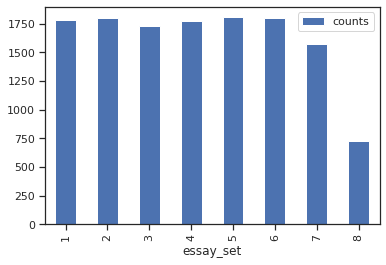

In [11]:
df.essay_set.value_counts().rename_axis('essay_set').reset_index(name='counts').sort_values(
    'essay_set').plot(kind='bar', x="essay_set", y="counts");

### Inspect Scores
Overall score distribution

In [12]:
df[['domain1_score','rater1_domain1','rater2_domain1']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
domain1_score,12976.0,6.800247,8.970705,0.0,2.0,3.0,8.0,60.0
rater1_domain1,12976.0,4.127158,4.212544,0.0,2.0,3.0,4.0,30.0
rater2_domain1,12976.0,4.137408,4.264330,0.0,2.0,3.0,4.0,30.0


Essay set score distribution

In [13]:
df.groupby('essay_set')['domain1_score','rater1_domain1','rater2_domain1'].describe().transpose()

essay_set                       1            2            3            4  \
domain1_score  count  1783.000000  1800.000000  1726.000000  1770.000000   
               mean      8.528323     3.415556     1.848204     1.432203   
               std       1.538565     0.774512     0.815157     0.939782   
               min       2.000000     1.000000     0.000000     0.000000   
               25%       8.000000     3.000000     1.000000     1.000000   
               50%       8.000000     3.000000     2.000000     1.000000   
               75%      10.000000     4.000000     2.000000     2.000000   
               max      12.000000     6.000000     3.000000     3.000000   
rater1_domain1 count  1783.000000  1800.000000  1726.000000  1770.000000   
               mean      4.260796     3.415556     1.741020     1.320339   
               std       0.842119     0.774512     0.777672     0.879825   
               min       1.000000     1.000000     0.000000     0.000000   
               25%       4.000000     3.000000     1.000000     1.000000   
               50%       4.000000     3.000000     2.000000     1.000000   
               75%       5.000000     4.000000     2.000000     2.000000   
               max       6.000000     6.000000     3.000000     3.000000   
rater2_domain1 count  1783.000000  1800.000000  1726.000000  1770.000000   
               mean      4.267527     3.436667     1.698725     1.316384   
               std       0.816287     0.775808     0.752710     0.877076   
               min       1.000000     1.000000     0.000000     0.000000   
               25%       4.000000     3.000000     1.000000     1.000000   
               50%       4.000000     3.000000     2.000000     1.000000   
               75%       5.000000     4.000000     2.000000     2.000000   
               max       6.000000     6.000000     3.000000     3.000000   

essay_set                       5            6            7           8  
domain1_score  count  1805.000000  1800.000000  1569.000000  723.000000  
               mean      2.408864     2.720000    16.062460   36.950207  
               std       0.970821     0.970630     4.585350    5.753502  
               min       0.000000     0.000000     2.000000   10.000000  
               25%       2.000000     2.000000    13.000000   33.000000  
               50%       2.000000     3.000000    16.000000   37.000000  
               75%       3.000000     3.000000    19.000000   40.000000  
               max       4.000000     4.000000    24.000000   60.000000  
rater1_domain1 count  1805.000000  1800.000000  1569.000000  723.000000  
               mean      2.221053     2.561111     8.023582   18.338866  
               std       0.988515     0.979296     2.424120    3.170147  
               min       0.000000     0.000000     0.000000    5.000000  
               25%       2.000000     2.000000     6.000000   16.000000  
               50%       2.000000     3.000000     8.000000   19.000000  
               75%       3.000000     3.000000    10.000000   20.000000  
               max       4.000000     4.000000    12.000000   30.000000  
rater2_domain1 count  1805.000000  1800.000000  1569.000000  723.000000  
               mean      2.221607     2.550000     8.038878   18.557400  
               std       0.992030     0.977655     2.517367    3.170669  
               min       0.000000     0.000000     0.000000    5.000000  
               25%       2.000000     2.000000     6.000000   16.000000  
               50%       2.000000     3.000000     8.000000   19.000000  
               75%       3.000000     3.000000    10.000000   20.000000  
               max       4.000000     4.000000    12.000000   30.000000

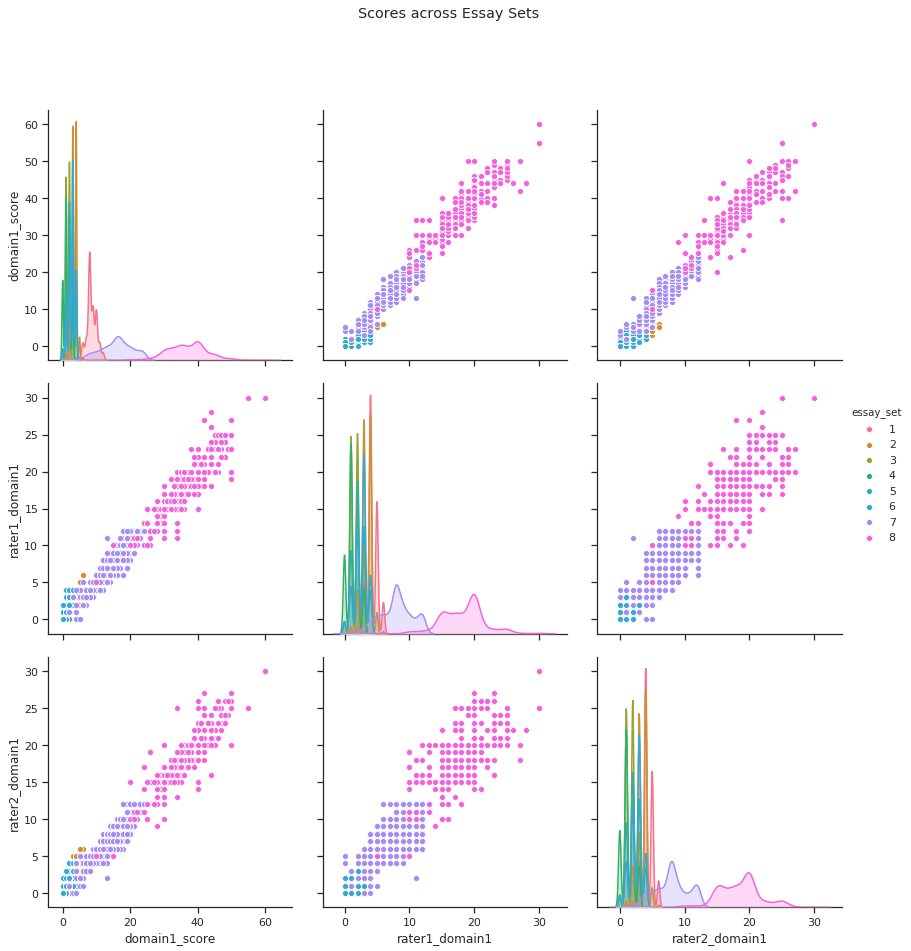

In [14]:
sns.pairplot(df, hue="essay_set", vars=['domain1_score', 'rater1_domain1', 'rater2_domain1'], palette="husl",
            height=4).fig.suptitle("Scores across Essay Sets", y=1.1);

In [15]:
# fraction = .2
fraction = 1
df = df.drop(columns=['essay_id', 'rater2_domain1', 'rater1_domain1']).sample(weights='essay_set',
                                                                              random_state=1, frac=fraction)

In [16]:
meta_features = ['essay_length', 'avg_sentence_length', 'avg_word_length']
grammar_features = ['sentiment', 'noun_phrases', 'syntax_errors']
redability_features = ['readability_index', 'difficult_words']

df.reindex(columns=meta_features + grammar_features + redability_features, fill_value=np.zeros)
essays = df['essay'].values

In [17]:
def add_meta_feature_columns(index, df, blob):
    
    # Essay Length (number of words)
    df.at[index, 'essay_length'] = len(blob.words)

    # Average Sentence Length
    sentence_lengths = [len(sentence.split(' ')) for sentence in blob.sentences]
    df.at[index, 'avg_sentence_length'] = mean(sentence_lengths)

    # Average Word Length
    word_lengths = [len(word) for word in blob.words]
    df.at[index, 'avg_word_length'] = mean(word_lengths)

    # Sentiment
    df.at[index, 'sentiment'] = blob.sentiment.polarity

In [18]:
def add_grammar_feature_columns(index, df, blob, essay):
    
    # Number of noun phrases
    df.at[index, 'noun_phrases'] = len(blob.noun_phrases)

    # Number of possible spelling and grammatical Mistakes
    # Takes significant amount of time
    print("Processed %5d essays for correctness..." % (index + 1), end="\r")
    languageTool = language_check.LanguageTool('en-US')
    df.at[index, 'syntax_errors'] = len(languageTool.check(essay))

In [19]:
def add_redability_feature_columns(index, df, essay):
    
    # Number of noun phrases
    df.at[index, 'readability_index'] = ts.automated_readability_index(essay)

    df.at[index, 'difficult_words'] = ts.difficult_words(essay)

In [20]:
print("Adding feature Columns...")

for i in range(df.shape[0]):
    blob = TextBlob(essays[i])

    add_meta_feature_columns(i, df, blob)
    
    add_grammar_feature_columns(i, df, blob, essays[i])
    
    add_redability_feature_columns(i, df, essays[i])

print("\nDone!")

Adding feature Columns...
Processed 12976 essays for correctness...
Done!


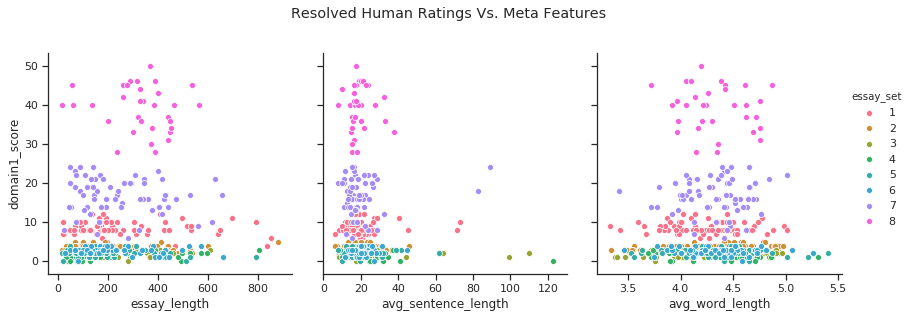

In [21]:
sns.pairplot(df.sample(n=500), hue="essay_set", x_vars=meta_features, y_vars=['domain1_score'], palette="husl",
            height=4).fig.suptitle("Resolved Human Ratings Vs. Meta Features", y=1.1);

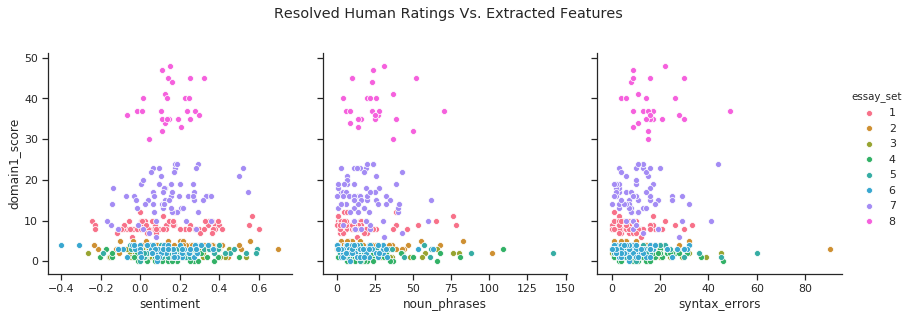

In [22]:
sns.pairplot(df.sample(n=500), hue="essay_set", x_vars=grammar_features, y_vars=['domain1_score'], palette="husl",
            height=4).fig.suptitle("Resolved Human Ratings Vs. Extracted Features", y=1.1);

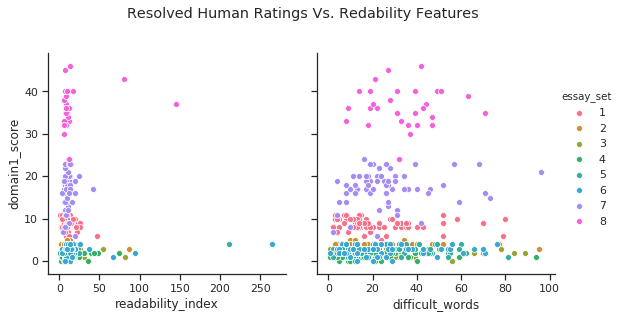

In [23]:
sns.pairplot(df.sample(n=500), hue="essay_set", x_vars=redability_features, y_vars=['domain1_score'], palette="husl",
            height=4).fig.suptitle("Resolved Human Ratings Vs. Redability Features", y=1.1);

In [24]:
df

,essay_set,essay,domain1_score,essay_length,avg_sentence_length,avg_word_length,sentiment,noun_phrases,syntax_errors,readability_index,difficult_words
8074,5,"In the memoir, ""Narciso Rodriguez"" by Narciso ...",4,231.0,16.357143,4.471861,0.082832,12.0,12.0,11.0,26.0
10912,7,The time I was patience was when I was @NUM1 y...,16,23.0,23.000000,4.608696,0.000000,1.0,0.0,12.0,5.0
6,1,Did you know that more and more people these d...,10,43.0,14.333333,4.395349,0.027083,2.0,2.0,6.8,5.0
6767,4,The author concludes the story with he paragra...,1,411.0,21.473684,4.990268,0.250740,48.0,14.0,14.3,59.0
4441,3,There are many ways that the features of the s...,2,87.0,43.500000,4.022989,-0.152778,4.0,4.0,19.8,6.0
...,...,...,...,...,...,...,...,...,...,...,...
1762,1,"Guaranteed, @NUM1 years from now we will still...",9,189.0,18.600000,4.455026,0.406000,17.0,10.0,11.0,25.0
1522,1,"Dear @CAPS1 @CAPS2 @CAPS3, @CAPS4 many people ...",10,73.0,14.600000,4.534247,0.123333,7.0,4.0,7.7,12.0
296,1,"Dear local Newspaper, I assume you've heard ab...",9,30.0,10.000000,3.566667,0.102778,2.0,1.0,0.9,2.0
1632,1,"To @CAPS1 @CAPS2 @ORGANIZATION1, Computers are...",8,166.0,27.000000,4.114458,0.029167,8.0,18.0,25.8,10.0


In [25]:
df.to_pickle('output/training_set_rel3.pkl')

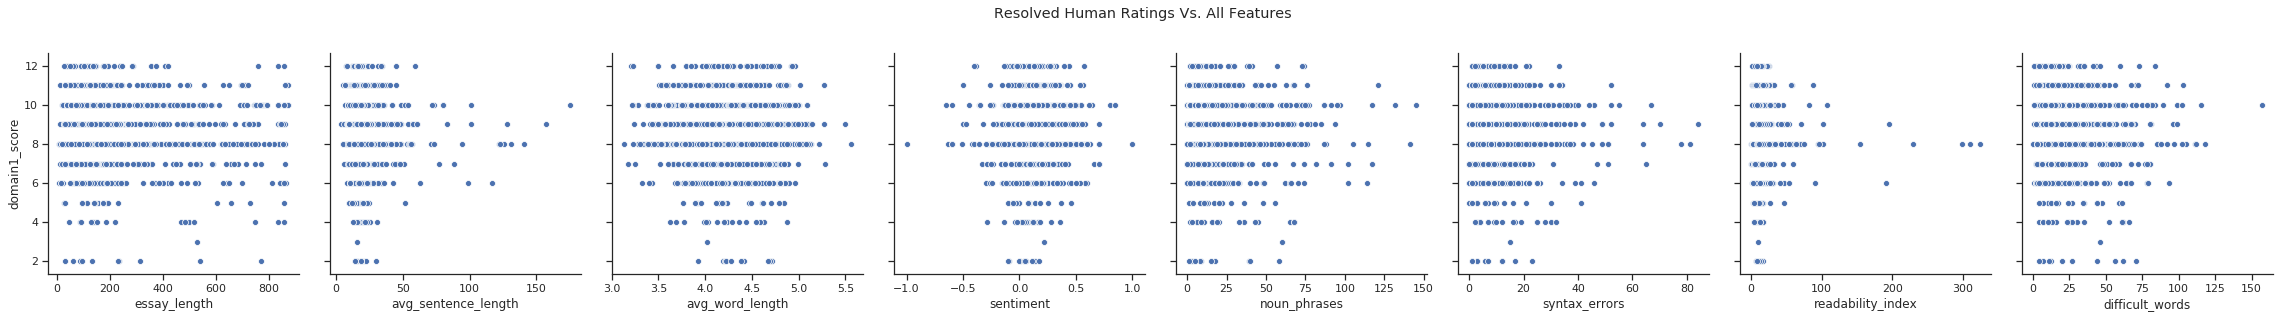

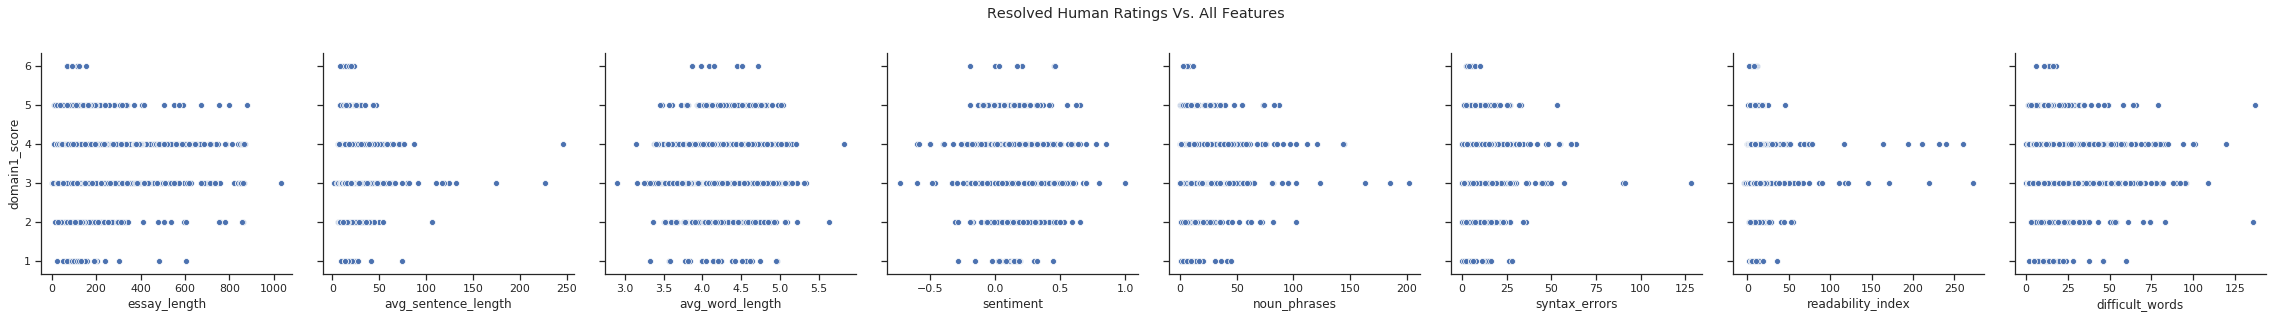

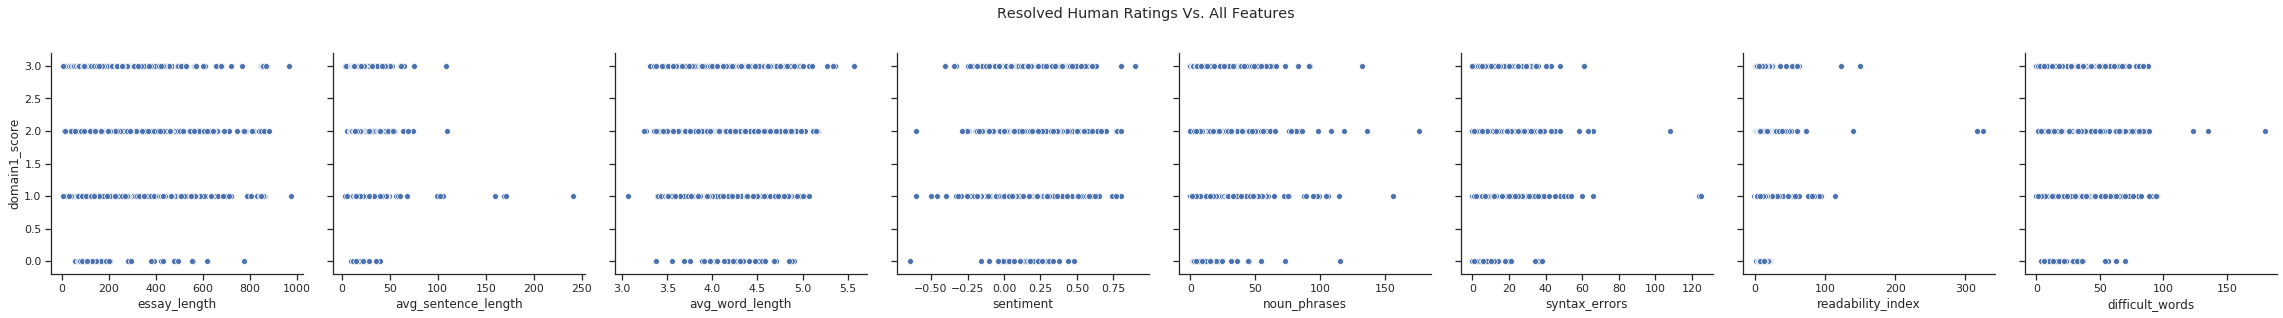

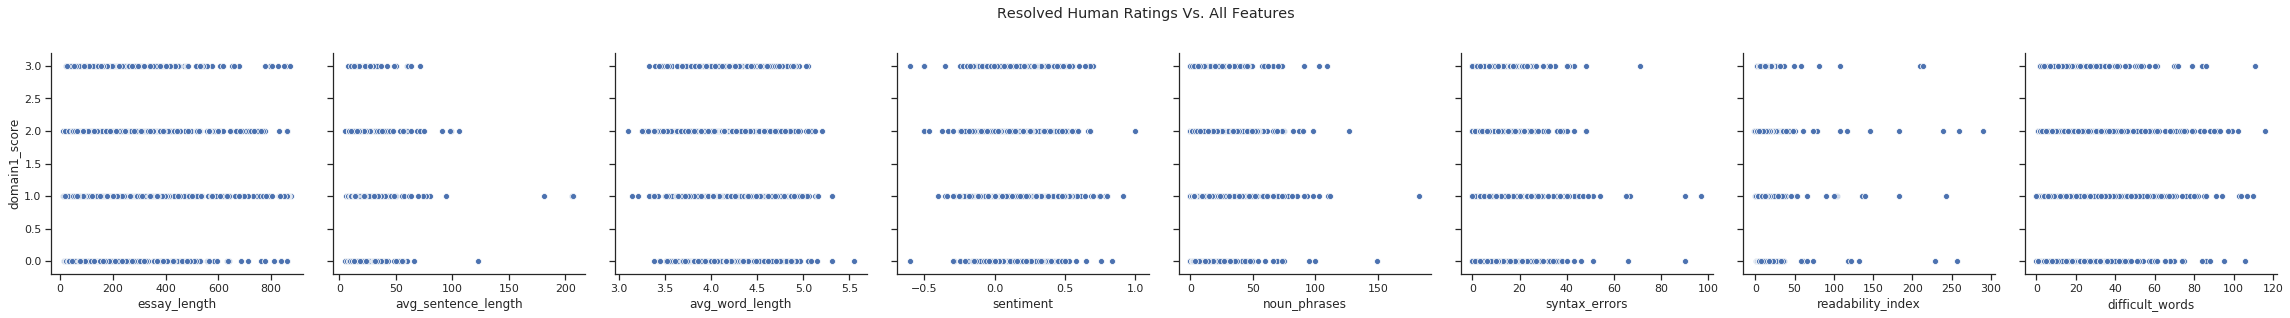

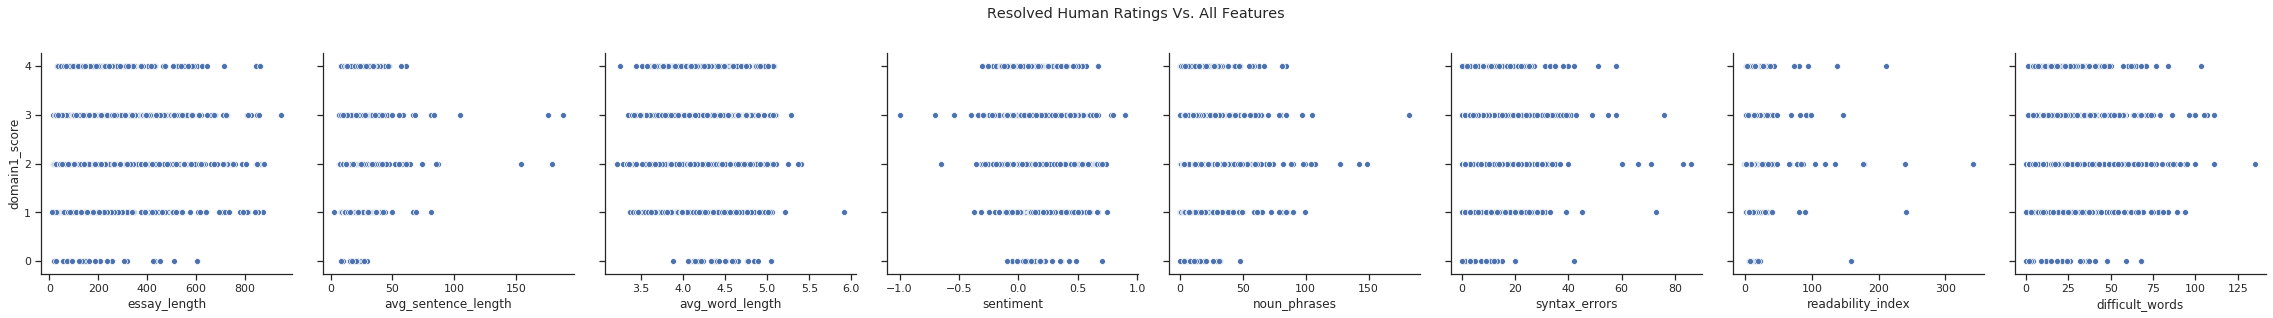

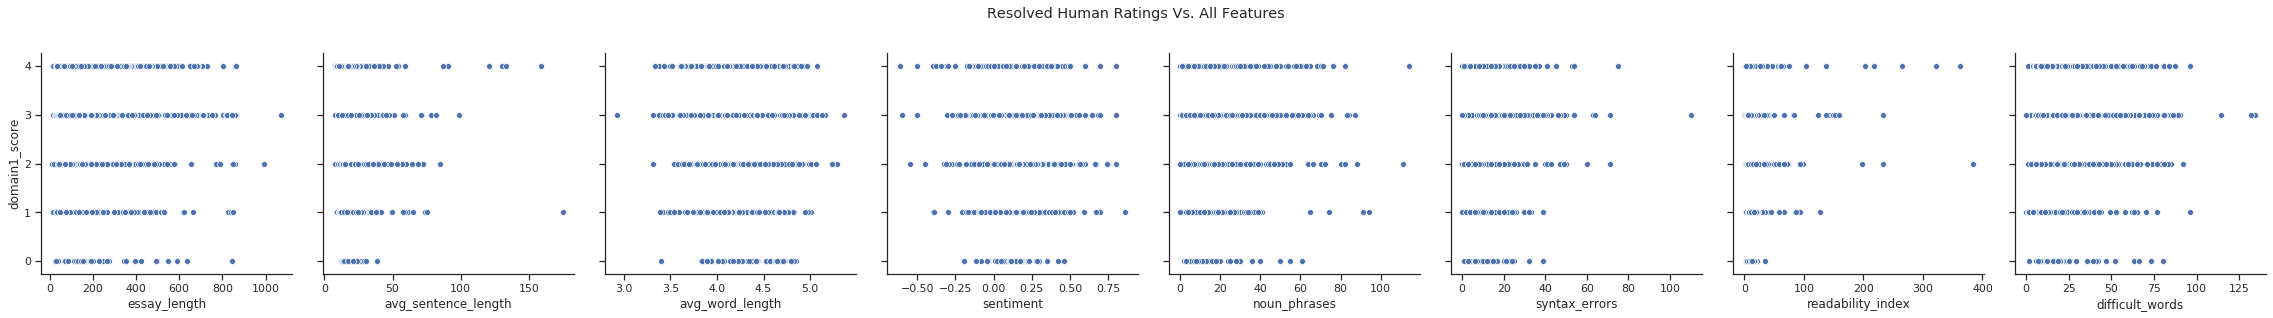

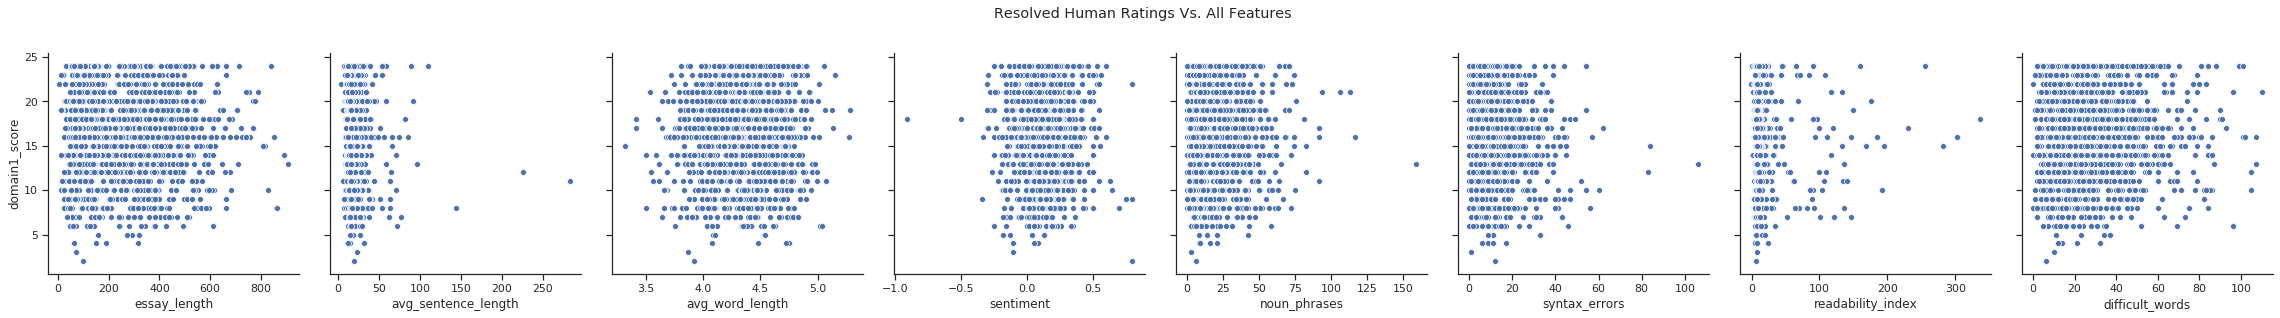

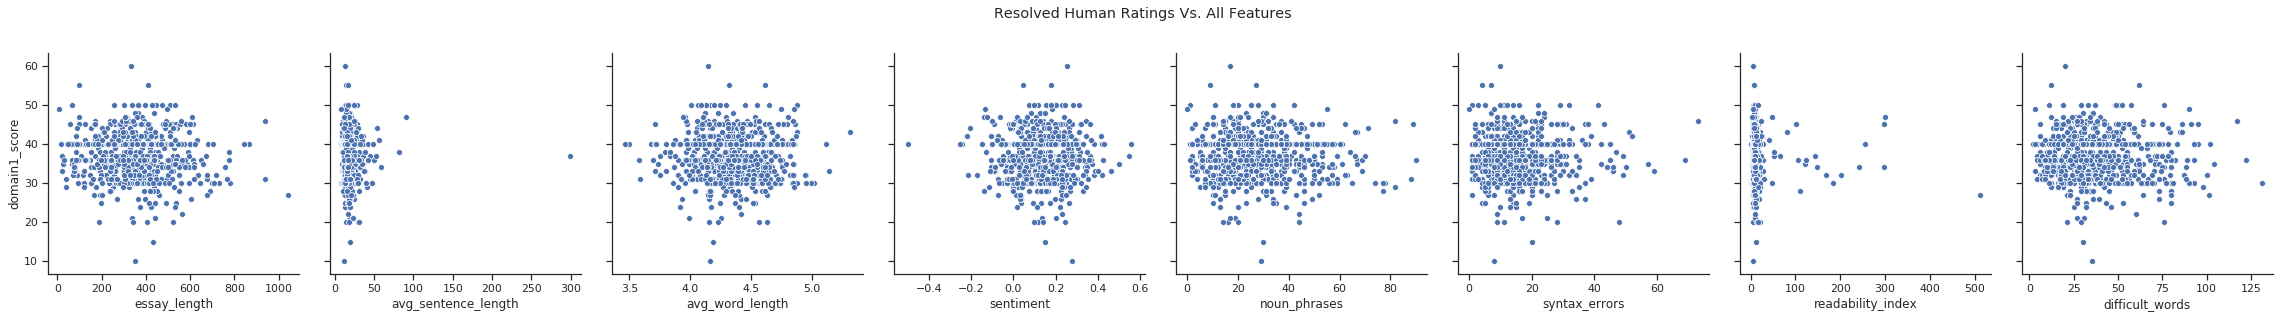

In [29]:
for i in range(8):
    sns.pairplot(df[df.essay_set == i+1], x_vars=meta_features + grammar_features + redability_features, 
                y_vars=['domain1_score'], palette="husl", height=4).fig.suptitle(
                "Resolved Human Ratings Vs. All Features", y=1.1);